# Determine confusability of selected faces between target emotions

### Created by Anita 

SVM classifications of elite face blendshapes within each iteration using SVM
- Classify group membership to patient or control group
- Classify target emotion separately for patients and controls, compare confusion matrices

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from scipy.stats import binomtest

import seaborn as sns; sns.set(font_scale=1.2)

In [147]:
#import data
all_df = pd.read_csv('processed_data/all_faces_coded.csv')

#iteration elite face sample
elite_df = all_df[all_df['eliteSelected']==1]

#selected face sample
selected_df = all_df[all_df['faceSelected']==1]

print(elite_df.groupby('Group')['ID'].count())
print(selected_df.groupby('Group')['ID'].count())

Group
HC    528
PT    592
Name: ID, dtype: int64
Group
HC    2093
PT    2109
Name: ID, dtype: int64


In [79]:
#specify sample
sample_list = {'elite': elite_df, 'selected': selected_df, 'all': all_df}

#split subjects into training and testing set
Participants = pd.Series(elite_df['ID'].unique())
Group = Participants.str.extract(r'S1([A-Z][A-Z])')

# Run SVM classification
# cross-validation metrics
params={
        'SVM__kernel': ['rbf'],
        'SVM__C': [.1,.5,1,10,30,40,50,75,100,500,1000],
        'SVM__gamma': [.001,.005,.01,.05,.07,.1,.5,1,5,10,50]
        }

pipeSteps=[('SVM',svm.SVC())]
pipeline = Pipeline(pipeSteps)

subTrain, subTest= train_test_split(Participants, test_size=.25, random_state=102, stratify=Group)

for i in sample_list:
    xTrain = (sample_list[i])[(sample_list[i])['ID'].isin(subTrain)].iloc[:,1:150]
    xTest = (sample_list[i])[(sample_list[i])['ID'].isin(subTest)].iloc[:,1:150]
    yTrain = (sample_list[i])[(sample_list[i])['ID'].isin(subTrain)]['Group']
    yTest = (sample_list[i])[(sample_list[i])['ID'].isin(subTest)]['Group']
    print(i, 'Train', xTrain.shape)
    print(i, 'Test', xTest.shape)

    # k-fold CV
    createGrid=GridSearchCV(pipeline,params,cv=10) # k-fold cross-validation: The k cross validation is used to divide the training set into k distinct subsets. Then every subset is used for training and others k-1 are used for validation in the entire training phase. This is done for better training of the classification task.
    createGrid.fit(xTrain,np.ravel(yTrain))
    print(f'{i} Best Fit params: \n {createGrid.best_params_}')

elite Train (832, 149)
elite Test (288, 149)
elite Best Fit params: 
 {'SVM__C': 0.5, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
selected Train (3159, 149)
selected Test (1043, 149)
selected Best Fit params: 
 {'SVM__C': 50, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
all Train (8320, 149)
all Test (2880, 149)
all Best Fit params: 
 {'SVM__C': 10, 'SVM__gamma': 5, 'SVM__kernel': 'rbf'}


In [145]:
param_dict = {
    'elite': {
        'k': 'rbf',
        'g': 1,
        'c': 0.5
        },
'selected' : {
        'k': 'rbf',
        'g': 1,
        'c': 50
        },
     'all' : {
        'k': 'rbf',
        'g': 5,
        'c': 10
     }}

#split subjects into training and testing set
Participants = pd.Series(elite_df['ID'].unique())
Group = Participants.str.extract(r'S1([A-Z][A-Z])')
subTrain, subTest= train_test_split(Participants, test_size=.25, random_state=102, stratify=Group)

for i in sample_list:
    xTrain = (sample_list[i])[(sample_list[i])['ID'].isin(subTrain)].iloc[:,1:150]
    xTest = (sample_list[i])[(sample_list[i])['ID'].isin(subTest)].iloc[:,1:150]
    yTrain = (sample_list[i])[(sample_list[i])['ID'].isin(subTrain)]['Group']
    yTest = (sample_list[i])[(sample_list[i])['ID'].isin(subTest)]['Group']
    print(i, 'Train', xTrain.shape)
    print(i, 'Test', xTest.shape)
    # generate model - parametrized
    model = svm.SVC(kernel=param_dict[i]['k'],C=param_dict[i]['c'],gamma=param_dict[i]['g'])  
    #SVC (classification > 0/1 estimate) & SVR (regression > a value estimate) commonly used
    model.fit(xTrain,np.ravel(yTrain))

    yPred = model.predict(xTest)

    #evaluate classifier accuracy
    accScore=metrics.accuracy_score(yTest, yPred)

    print(i, 'Classification Report:')
    print(classification_report(yTest,yPred))

    print(f"{i} Sample Accuracy: {accScore}")

    # binomial test
    binomP=binomtest(int(accScore*len(yTest)), n=len(yTest), p=1/len(Group[0].unique()))
    print(i, "Binomial test p = ", binomP.pvalue)


elite Train (832, 149)
elite Test (288, 149)
elite Classification Report:
              precision    recall  f1-score   support

          HC       0.65      0.22      0.33       144
          PT       0.53      0.88      0.66       144

    accuracy                           0.55       288
   macro avg       0.59      0.55      0.50       288
weighted avg       0.59      0.55      0.50       288

elite Sample Accuracy: 0.5520833333333334
elite Binomial test p =  0.08730426143324102
selected Train (3159, 149)
selected Test (1043, 149)
selected Classification Report:
              precision    recall  f1-score   support

          HC       0.61      0.32      0.42       597
          PT       0.45      0.73      0.55       446

    accuracy                           0.50      1043
   macro avg       0.53      0.52      0.49      1043
weighted avg       0.54      0.50      0.48      1043

selected Sample Accuracy: 0.4956855225311601
selected Binomial test p =  0.8043712949497714
all Trai

In [149]:
#SVM emotion classification for patients
#filter patient and control samples
PT_df=selected_df[selected_df['Group']=='PT']

Participants = pd.Series(PT_df['ID'].unique())
emotionList=selected_df['TargetEmotion'].unique()

subTrain, subTest= train_test_split(Participants, test_size=.25, random_state=102)
xTrain = PT_df[PT_df['ID'].isin(subTrain)].iloc[:,1:150]
xTest = PT_df[PT_df['ID'].isin(subTest)].iloc[:,1:150]
yTrain = PT_df[PT_df['ID'].isin(subTrain)]['TargetEmotion']
yTest = PT_df[PT_df['ID'].isin(subTest)]['TargetEmotion']

print('Train set shape:', xTrain.shape)
print('Test set shape:', xTest.shape)
print('Train label length:', len(yTrain))
print('Test label length:', len(yTest))
params={
    'SVM__kernel': ['rbf'],
    'SVM__C': [.1,.5,1,10,30,40,50,75,100,500,1000],
    'SVM__gamma': [.001,.005,.01,.05,.07,.1,.5,1,5,10,50]
}

pipeSteps=[('SVM',svm.SVC())]
pipeline = Pipeline(pipeSteps)

#k-fold CV. NB number of folds affects outcome... check on this 
createGrid=GridSearchCV(pipeline,params,cv=5) # k-fold cross-validation: The k cross validation is used to divide the training set into k distinct subsets. Then every subset is used for training and others k-1 are used for validation in the entire trainging phase. This is done for the better training of the classification task.
createGrid.fit(xTrain,np.ravel(yTrain))
print(f'Best Fit params: \n {createGrid.best_params_}')

# generate model - parametrized
k=createGrid.best_params_['SVM__kernel']
c=createGrid.best_params_['SVM__C']
g=createGrid.best_params_['SVM__gamma']

model = svm.SVC(kernel=k,C=c,gamma=g)  #SVC (classification > 0/1 estimate) & SVR (regression > a value estimate) are the two most oftenly used
model.fit(xTrain,np.ravel(yTrain))

yPred = model.predict(xTest)

#evaluate classifier accuracy
accScore=metrics.balanced_accuracy_score(yTest, yPred)

print(f"Accuracy (relative to chance level = {1/len(emotionList)}): {accScore}")

print('Classification Report:')
print(classification_report(yTest,yPred))

# binomial test
binomP=binomtest(int(accScore*len(yTest)), n=len(yTest), p=1/len(emotionList))
print("Binomial test p = ", binomP.pvalue)

# confusion matrix
PT_cnfMatrix = metrics.confusion_matrix(yTest.values,yPred,labels=emotionList)

Train set shape: (1470, 149)
Test set shape: (639, 149)
Train label length: 1470
Test label length: 639
Best Fit params: 
 {'SVM__C': 1, 'SVM__gamma': 0.07, 'SVM__kernel': 'rbf'}
Accuracy (relative to chance level = 0.3333333333333333): 0.7677538897540347
Classification Report:
              precision    recall  f1-score   support

       Angry       0.70      0.82      0.76       233
     Fearful       0.75      0.60      0.67       204
       Happy       0.88      0.88      0.88       202

    accuracy                           0.77       639
   macro avg       0.78      0.77      0.77       639
weighted avg       0.77      0.77      0.77       639

Binomial test p =  2.1692699423029533e-111


In [150]:
#SVM emotion classification for controls
#filter control samples
HC_df=selected_df[selected_df['Group']=='HC']
Participants = pd.Series(HC_df['ID'].unique())

subTrain, subTest= train_test_split(Participants, test_size=.25, random_state=102)
xTrain = HC_df[HC_df['ID'].isin(subTrain)].iloc[:,1:150]
xTest = HC_df[HC_df['ID'].isin(subTest)].iloc[:,1:150]
yTrain = HC_df[HC_df['ID'].isin(subTrain)]['TargetEmotion']
yTest = HC_df[HC_df['ID'].isin(subTest)]['TargetEmotion']

print('Train set shape:', xTrain.shape)
print('Test set shape:', xTest.shape)
print('Train label length:', len(yTrain))
print('Test label length:', len(yTest))
params={
    'SVM__kernel': ['rbf'],
    'SVM__C': [.1,.5,1,10,30,40,50,75,100,500,1000],
    'SVM__gamma': [.001,.005,.01,.05,.07,.1,.5,1,5,10,50]
}

pipeSteps=[('SVM',svm.SVC())]
pipeline = Pipeline(pipeSteps)

#k-fold CV. NB number of folds affects outcome... check on this 
createGrid=GridSearchCV(pipeline,params,cv=5) # k-fold cross-validation: The k cross validation is used to divide the training set into k distinct subsets. Then every subset is used for training and others k-1 are used for validation in the entire trainging phase. This is done for the better training of the classification task.
createGrid.fit(xTrain,np.ravel(yTrain))
print(f'Best Fit params: \n {createGrid.best_params_}')

# generate model - parametrized
k=createGrid.best_params_['SVM__kernel']
c=createGrid.best_params_['SVM__C']
g=createGrid.best_params_['SVM__gamma']

model = svm.SVC(kernel=k,C=c,gamma=g)  #SVC (classification > 0/1 estimate) & SVR (regression > a value estimate) are the two most oftenly used
model.fit(xTrain,np.ravel(yTrain))

yPred = model.predict(xTest)

# evaluate classifier accuracy
accScore=metrics.balanced_accuracy_score(yTest, yPred)

print(f"Accuracy (relative to chance level = {1/len(emotionList)}): {accScore}")

print('Classification Report:')
print(classification_report(yTest,yPred))

# binomial test
binomP=binomtest(int(accScore*len(yTest)), n=len(yTest), p=1/len(emotionList))
print("Binomial test p = ", binomP.pvalue)

# confusion matrix
HC_cnfMatrix = metrics.confusion_matrix(yTest.values,yPred,labels=emotionList)

Train set shape: (1536, 149)
Test set shape: (557, 149)
Train label length: 1536
Test label length: 557
Best Fit params: 
 {'SVM__C': 10, 'SVM__gamma': 0.07, 'SVM__kernel': 'rbf'}
Accuracy (relative to chance level = 0.3333333333333333): 0.8574453246713333
Classification Report:
              precision    recall  f1-score   support

       Angry       0.93      0.91      0.92       205
     Fearful       0.80      0.74      0.77       171
       Happy       0.84      0.93      0.88       181

    accuracy                           0.86       557
   macro avg       0.86      0.86      0.86       557
weighted avg       0.86      0.86      0.86       557

Binomial test p =  3.865539701428396e-144


/var/folders/yx/lz0kt1c90d5g4bpdz40j6vkw0000gn/T/ipykernel_5850/1054869758.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1.5, 1])


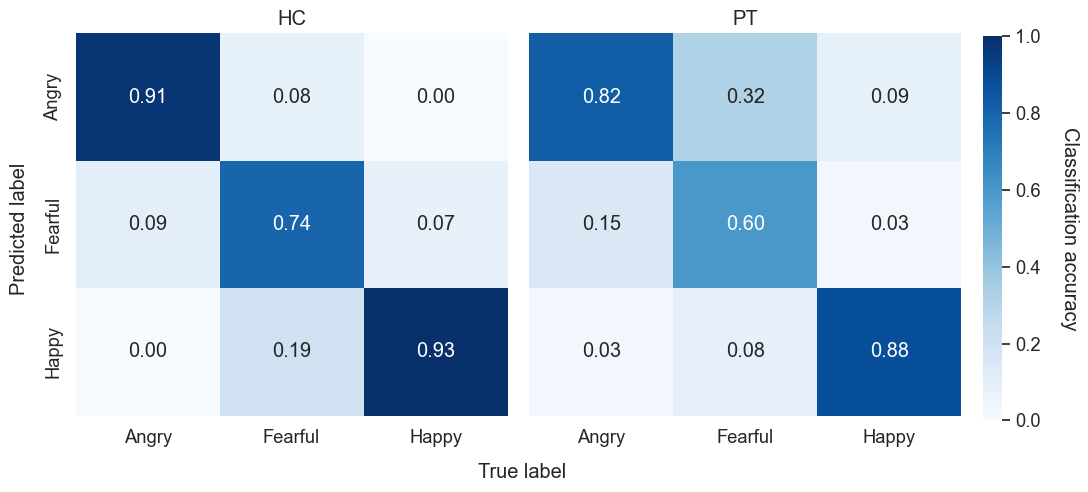

In [151]:
# sns approach to confusion matrix
HC_cm = pd.DataFrame(HC_cnfMatrix,range(len(emotionList)),range(len(emotionList)))
HC_cm.index=emotionList
HC_cm.columns=emotionList

PT_cm = pd.DataFrame(PT_cnfMatrix,range(len(emotionList)),range(len(emotionList)))
PT_cm.index=emotionList
PT_cm.columns=emotionList


HC_cm['Angry'] = HC_cnfMatrix[0,:]/HC_cnfMatrix[0,:].sum()
HC_cm['Fearful'] = HC_cnfMatrix[1,:]/HC_cnfMatrix[1,:].sum()
HC_cm['Happy'] = HC_cnfMatrix[2,:]/HC_cnfMatrix[2,:].sum()

PT_cm['Angry'] = PT_cnfMatrix[0,:]/PT_cnfMatrix[0,:].sum()
PT_cm['Fearful'] = PT_cnfMatrix[1,:]/PT_cnfMatrix[1,:].sum()
PT_cm['Happy'] = PT_cnfMatrix[2,:]/PT_cnfMatrix[2,:].sum()

fig, ax = plt.subplots(1,2, sharey=True)
cbar_ax = fig.add_axes([1.5, 0.1, .03, 0.8])
ax1 = sns.heatmap(HC_cm, annot=True, cmap="Blues", ax=ax[0], fmt='.2f', cbar=False).set_title('HC')
ax2 = sns.heatmap(PT_cm, annot=True, cmap="Blues", ax=ax[1], fmt='.2f', vmax=1, cbar_ax=cbar_ax, vmin=0).set_title('PT')

fig.text(0.78, -0.02, 'True label', ha='center')
fig.text(-0.02, 0.5, 'Predicted label', va='center', rotation='vertical')
fig.text(1.62, 0.5, 'Classification accuracy', va='center', rotation=270)

fig.tight_layout(rect=[0, 0, 1.5, 1])

plt.savefig('plots/confusion.png', dpi=300, bbox_inches = 'tight')

In [152]:
joined_cnf = np.concatenate((HC_cnfMatrix, PT_cnfMatrix))
df = pd.DataFrame(joined_cnf)
df.to_csv("processed_data/joined_cnf.csv")

/var/folders/yx/lz0kt1c90d5g4bpdz40j6vkw0000gn/T/ipykernel_5850/80976138.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1.5, 1])


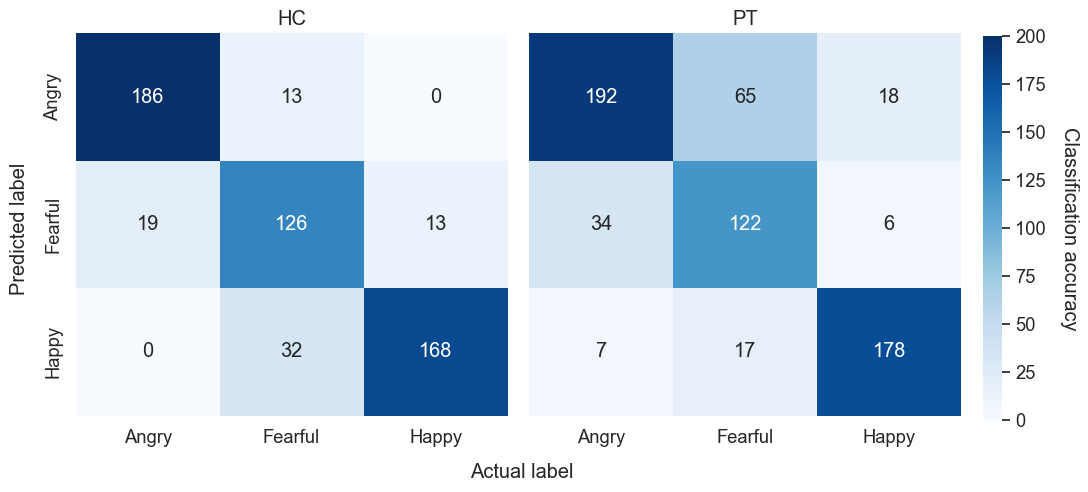

In [159]:
fig, ax = plt.subplots(1,2, sharey=True)
cbar_ax = fig.add_axes([1.5, 0.1, .03, 0.8])
ax1 = sns.heatmap(HC_cnfMatrix.transpose(), annot=True, cmap="Blues", ax=ax[0], fmt='.0f', cbar=False, xticklabels=emotionList, yticklabels=emotionList).set_title('HC')
ax2 = sns.heatmap(PT_cnfMatrix.transpose(), annot=True, cmap="Blues", ax=ax[1], fmt='.0f', cbar_ax=cbar_ax, vmin=0, vmax=200, xticklabels=emotionList, yticklabels=emotionList).set_title('PT')

fig.text(0.78, -0.02, 'Actual label', ha='center')
fig.text(-0.02, 0.5, 'Predicted label', va='center', rotation='vertical')
fig.text(1.62, 0.5, 'Classification accuracy', va='center', rotation=270)

fig.tight_layout(rect=[0, 0, 1.5, 1])

plt.savefig('plots/confusion_vals.png', dpi=300, bbox_inches = 'tight')